TODO

In [ ]:
SAVE_ON_DRIVE = True
TYPE = 'Train'

# Dataset initialization


### Download Data

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/LoveDA/Train'
if (os.path.exists("./Train") == False):
    if (os.path.exists("/content/drive/MyDrive/LoveDA/Train.zip")):
        print("Dataset available on own drive, unzipping...")
        !unzip -q /content/drive/MyDrive/LoveDA/Train.zip -d ./
    else:
        print("Downloading dataset...")
        !wget -O Train.zip "https://zenodo.org/records/5706578/files/Train.zip?download=1"
        if(SAVE_ON_DRIVE):
            print("Saving dataset on drive...")
            !cp Train.zip /content/drive/MyDrive/LoveDA/
        !unzip -q Train.zip -d ./

else:
    print("Dataset already in local")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already in local


### Import Boundaries

In [ ]:
# Paths
rural_boundaries_path = "./Train/Rural/boundaries_png"
rural_masks_path = './Train/Rural/masks_png'

urban_boundaries_path = "./Train/Urban/boundaries_png"
urban_masks_path = './Train/Urban/masks_png'
drive_rural_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Rural/boundaries_png'
drive_urban_boundaries_path = '/content/drive/MyDrive/LoveDA/boundaries/Urban/boundaries_png'

boundaries_paths = [rural_boundaries_path, urban_boundaries_path]

# Make dir inside ./Train/...
for boundaries_path in boundaries_paths:
    if (os.path.exists(boundaries_path) == False):
        print(f"Creating {boundaries_path}...")
        os.makedirs(boundaries_path)
    else:
        print(f"{boundaries_path} exists...")


# Check if files are already present
rural_file_count = len([name for name in os.listdir(rural_boundaries_path) if os.path.isfile(os.path.join(rural_boundaries_path, name))])
rural_mask_file_count = len([name for name in os.listdir(rural_masks_path) if os.path.isfile(os.path.join(rural_masks_path, name))])
urban_file_count = len([name for name in os.listdir(urban_boundaries_path) if os.path.isfile(os.path.join(urban_boundaries_path, name))])
urban_mask_file_count = len([name for name in os.listdir(urban_masks_path) if os.path.isfile(os.path.join(urban_masks_path, name))])

if (rural_file_count != rural_mask_file_count):
    print(f"Importing boundaries, as we have {rural_file_count} rural boundaries as of now...")
    shutil.copytree(drive_rural_boundaries_path, rural_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Rural boundaries already present, {rural_file_count} files...")

if (urban_file_count != urban_mask_file_count):
    print(f"Importing boundaries, as we have {urban_file_count} urban boundaries as of now...")
    shutil.copytree(drive_urban_boundaries_path, urban_boundaries_path, dirs_exist_ok=True)
else:
    print(f"Urban boundaries already present, {urban_file_count} files...")

./Train/Rural/boundaries_png exists...
./Train/Urban/boundaries_png exists...
Rural boundaries already present, 1366 files...
Urban boundaries already present, 1156 files...


### Dataset Definition

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import random


def pil_loader(path, color_type):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(color_type)

class LoveDADataset(Dataset):
    def __init__(self, transforms, split = 'Urban', type = 'Train', validation_ratio=0.2, seed=265637):
        # Validate type input
        if type not in ['Train', 'Validation']:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation'.")
        self.directory = []
        directory_path = os.path.join('./Train', split, 'images_png')
        # Check if the directory exists
        if not os.path.exists(directory_path):
            raise FileNotFoundError(f"Directory not found: {directory_path}")
        # Get all image paths
        all_images = [os.path.join(directory_path, entry) for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))]
        # Shuffle images for random splitting
        random.seed(seed)
        random.shuffle(all_images)
        # Split into training and validation sets
        split_idx = int(len(all_images) * (1 - validation_ratio))
        if type == 'Train':
            self.directory = all_images[:split_idx]
        elif type == 'Validation':
            self.directory = all_images[split_idx:]
        else:
            raise ValueError("Invalid type. Expected 'Train' or 'Validation'.")
        self.transforms = transforms
        print(f"Dataset size: {len(self.directory)}")

      # Define albumentations transforms
        """
        # WITH AUGMENTATIONS
          self.transform = A.Compose([
            A.RandomCrop(256, 256),
            A.OneOf([
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1)
            ], p=0.75),
            A.Normalize(mean=(123.675, 116.28, 103.53),
                        std=(58.395, 57.12, 57.375),
                        max_pixel_value=1.0, always_apply=True),
            ToTensorV2()
        ])
      """

    def __len__(self):
        return len(self.directory)

    def __getitem__(self, idx):
        image_path = self.directory[idx]
        image = pil_loader(image_path, 'RGB')
        mask_path = image_path.replace('images_png', 'masks_png')
        boundaries_path = image_path.replace('images_png', 'boundaries_png')

        mask = pil_loader(mask_path, 'L')
        boundaries = pil_loader(boundaries_path, 'L')

        # Apply transformations
        augmented = self.transforms(image=np.array(image), mask=np.array(mask), boundaries=np.array(boundaries))

        image = T.Compose([T.ToTensor()])(augmented['image'])

        mask = augmented['mask']
        mask = torch.from_numpy(mask).long()
        mask = mask-1

        boundaries = augmented['boundaries']
        boundaries = torch.from_numpy(boundaries)

        return image, mask, image_path, boundaries

### Dataset Utils

In [ ]:
from collections import OrderedDict
COLOR_MAP = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(34, 139, 34),
    Agricultural=(255, 195, 128),
)

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6,
)
inverted_label_map = OrderedDict((v, k) for k, v in LABEL_MAP.items())


def getLabelColor(label):
    # Default color for unclassified labels
    default_color = np.array([128, 128, 128])  # Gray

    # Check if label exists in inverted_label_map
    label_name = inverted_label_map.get(label, None)
    if label_name is None or label_name not in COLOR_MAP:
        return default_color  # Return default color for unclassified

    # Return the mapped color
    label_color = np.array(COLOR_MAP[label_name])
    return label_color


def getLegendHandles():
  handles = [mpatches.Patch(color=getLabelColor(i)/255, label=inverted_label_map[i]) for i in range(0, len(LABEL_MAP))]
  handles.append(mpatches.Patch(color=getLabelColor(-1)/255, label='Unclassified'))
  return handles

def new_colors_mask(mask):
  new_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
  for i, row in enumerate(mask):
    for j, cell in enumerate(row):
      new_image[i][j] = getLabelColor(cell.item())
  return new_image



### Dataset Debug

In [ ]:
# # Comment this cell to save GPU time

# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# import matplotlib.patches as mpatches

# train_dataset = LoveDADataset(type='Train', seed=222)
# print(train_dataset.__len__())

# # Get item
# image, mask, path, bd = train_dataset.__getitem__(88)

# # Show path
# print(f"Image is at {path}")

# # Show image
# image = image.permute(1, 2, 0)
# image = image.numpy()
# plt.imshow(image)

# # Show mask
# new_image = new_colors_mask(mask)
# plt.imshow(image)
# plt.show()
# plt.legend(handles=getLegendHandles(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
# plt.imshow(new_image)
# plt.show()

# # Show boundaries
# # for row in bd:
# #     for col in row:
# #         if col != 0 and col != 1:
# #             print(col)
# bd = bd.numpy()
# plt.imshow(bd)


# Initialize model

### PIDNet Util Modules

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)



if __name__ == '__main__':


    x = torch.rand(4, 64, 32, 64).cuda()
    y = torch.rand(4, 64, 32, 64).cuda()
    z = torch.rand(4, 64, 32, 64).cuda()
    net = PagFM(64, 16, with_channel=True).cuda()

    out = net(x,y)

### PIDNet Definition

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

### Load PIDNet Model

In [ ]:
import gdown
import tarfile

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)
# Then keep as tar, as it's already the correct format to feed the model

# Create a config object with required parameters
class Config:
    class MODEL:
        NAME = 'pidnet_s'  # or 'pidnet_m' or 'pidnet_l'
        PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
    class DATASET:
        NUM_CLASSES = len(LABEL_MAP)

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
# model = get_pred_model('s', len(LABEL_MAP))

<ipython-input-128-d799b7f58ec7>:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


### Model Debugging

In [ ]:
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# train_dataset = LoveDADataset(type='Train')
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# model = model.train()
# model = model.to('cuda')

# for img, mask, _ in train_loader:
#     print(f"iamge shape: {img.shape}")
#     print(f"mask shape: {mask.shape}")

#     img = img.to('cuda')
#     outputs = model(img)

#     # bilinear interpolation
#     h, w = mask.size(1), mask.size(2)
#     ph, pw = outputs[0].size(2), outputs[0].size(3)
#     if ph != h or pw != w:
#         for i in range(len(outputs)):
#             outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear',
#                                        align_corners=True)

#     for output in outputs:
#       print(output.shape)
#     break

# print("===================== Original Image =====================")
# plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
# plt.show()

# print("===================== Ground Truth =====================")
# plt.imshow(mask[0].cpu().numpy())
# plt.show()

# print("===================== Predicted Mask =====================")
# plt.imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
# plt.show()

# Training & Dataset creation

### Ablations and Macros

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

LR = 2*1e-3            # The initial Learning Rate -- I increased it using quadratic rule in relation with batch size
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 14      # How many epochs before decreasing learning rate (if using a step-down policy) -- Trying to keep a 2:3 ratio with NUM_EPOCHS
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 1
NUM_CLASSES = len(LABEL_MAP)
BATCH_SIZE = 64

### Setup, Create Datasets and DataLoaders. With annexed transforms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomScale, RandomCrop, GaussNoise, ElasticTransform, Rotate, Resize, OneOf, Normalize
from albumentations.pytorch import ToTensorV2



#How big should be the image that we feed to the model?
RESIZE = 512
# DEFINE TRANSFORMATIONS HERE
# To Tensor is not needed since its performed inside the getitem
# Normalization too

AUGMENTATIONS = {
    'None': Compose([
            Resize(RESIZE, RESIZE),
    ], additional_targets={"boundaries": "mask"}),
    'Normalize': Compose([
            Resize(RESIZE, RESIZE),
            Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True)
                      ], additional_targets={"boundaries": "mask"}),
    '1': Compose([
                  HorizontalFlip(p=0.5),  # 50% chance of applying horizontal flip
                  RandomRotate90(p=0.5),  # 50% chance of rotating by 90 degrees
                  RandomScale(scale_limit=0.1, p=0.5),  # Random scaling with 10% limit
                  OneOf([
                      RandomCrop(RESIZE, RESIZE),  # Random crop to resize
                      Resize(RESIZE, RESIZE)
                  ], p=1),
                  GaussNoise(var_limit=(10, 50), p=0.5),  # Add Gaussian noise
                  ElasticTransform(p=0.5),  # Elastic transformation
                  Normalize(mean=(123.675, 116.28, 103.53), std=(58.395, 57.12, 57.375), max_pixel_value=1.0, always_apply=True)
                  ], additional_targets={"boundaries": "mask"})
}

CHOOSE_TRANSFORM = '1'
transforms = AUGMENTATIONS[CHOOSE_TRANSFORM]

# Dataset and Loader
train_dataset = LoveDADataset(transforms=transforms,split='Urban', type='Train', validation_ratio=0.2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

validation_dataset = LoveDADataset(transforms=transforms, split='Urban', type='Validation', validation_ratio=0.2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)


# Model is defined some cells above, in LoadPidNetModel

# Optimizier and Scheduler
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Dataset size: 924
Dataset size: 232


### Losses

In [ ]:
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

def boundary_loss(bd_pre, bd_gt):
    loss = 20.0 * weighted_bce(bd_pre, bd_gt)
    return loss

# TODO EXTRA add weights=class_weights to nn.CrossEntropyLoss()
# TODO EXTRA use OHCE instead of basic one
def cross_entropy(score, target):
    compute_ce_loss = nn.CrossEntropyLoss(ignore_index=-1)

    # See paper for weights. In order of loss index: (0.4, 20, 1, 1) # But on cfg they set everything to 0.5
    balance_weights = [0.4, 1]
    sb_weights = 1

    # print(f"DEBUG: inside cross_entropy: len(score) = {len(score)}")
    if len(balance_weights) == len(score):
        return sum([w * compute_ce_loss(x, target) for (w, x) in zip(balance_weights, score)])
    elif len(score) == 1:
        return sb_weights * compute_ce_loss(score[0], target)
    else:
        raise ValueError("lengths of prediction and target are not identical!")

sem_loss = cross_entropy
bd_loss = boundary_loss

### Training Loop

DEVICE is cuda
Starting epoch 1/20, LR = [0.002]
Loss at batch 0: 16.828990936279297
Loss at batch 1: 16.01665496826172
Loss at batch 2: 15.15986442565918
Loss at batch 3: 14.629020690917969
Loss at batch 4: 13.346529006958008
Loss at batch 5: 12.720989227294922
Loss at batch 6: 11.982601165771484
Loss at batch 7: 11.108657836914062
Loss at batch 8: 10.809234619140625
Loss at batch 9: 9.498273849487305
Loss at batch 10: 9.506359100341797
Loss at batch 11: 8.507926940917969
Loss at batch 12: 8.216833114624023
Loss at batch 13: 8.072748184204102
Epoch 1, Loss 19.625231742858887
model succesfully saved on drive. loss went down to 19.625231742858887
[EPOCH 1] Avg. Loss: 0.18571951346737997


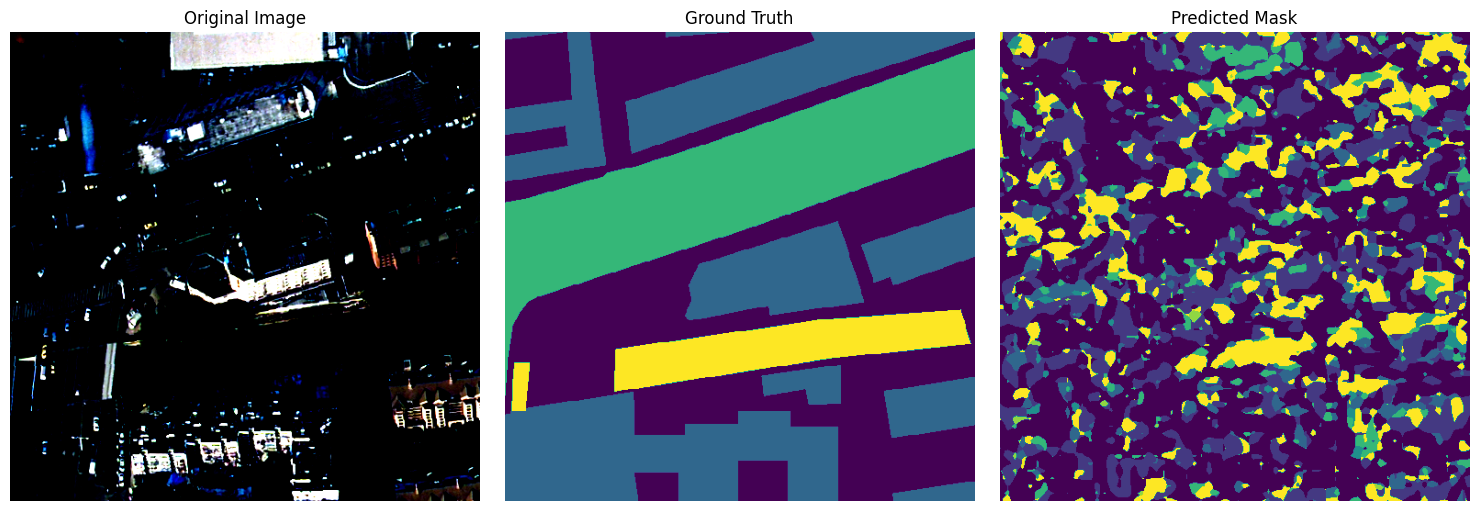

Starting epoch 2/20, LR = [0.002]
Loss at batch 0: 7.643509387969971
Loss at batch 1: 7.503506183624268
Loss at batch 2: 7.710116386413574
Loss at batch 3: 7.408022880554199
Loss at batch 4: 6.552116394042969
Loss at batch 5: 6.519623279571533
Loss at batch 6: 6.684072494506836
Loss at batch 7: 6.287613391876221
Loss at batch 8: 6.051891326904297
Loss at batch 9: 5.899625301361084
Loss at batch 10: 6.189319610595703
Loss at batch 11: 5.686603546142578
Loss at batch 12: 6.205172538757324
Loss at batch 13: 5.499963760375977
Epoch 2, Loss 17.008389949798584


model succesfully saved on drive. loss went down to 17.008389949798584
[EPOCH 2] Avg. Loss: 0.10250129071729523


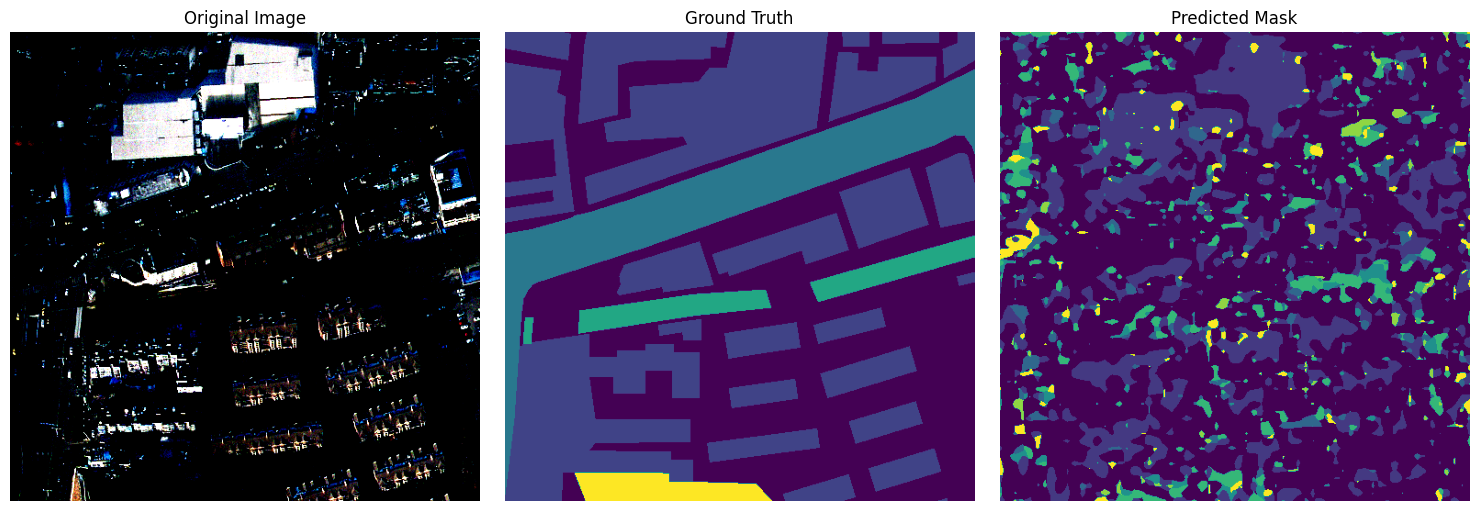

Starting epoch 3/20, LR = [0.002]
Loss at batch 0: 5.714958190917969
Loss at batch 1: 5.544036388397217
Loss at batch 2: 5.648233890533447
Loss at batch 3: 5.385346412658691
Loss at batch 4: 5.05436372756958
Loss at batch 5: 5.164788722991943
Loss at batch 6: 5.222200870513916
Loss at batch 7: 4.967216968536377
Loss at batch 8: 5.147938251495361
Loss at batch 9: 5.277948379516602
Loss at batch 10: 4.962911128997803
Loss at batch 11: 4.662962436676025
Loss at batch 12: 4.866336822509766
Loss at batch 13: 4.882196426391602
Epoch 3, Loss 15.43238878250122


model succesfully saved on drive. loss went down to 15.43238878250122
[EPOCH 3] Avg. Loss: 0.08091678417154721


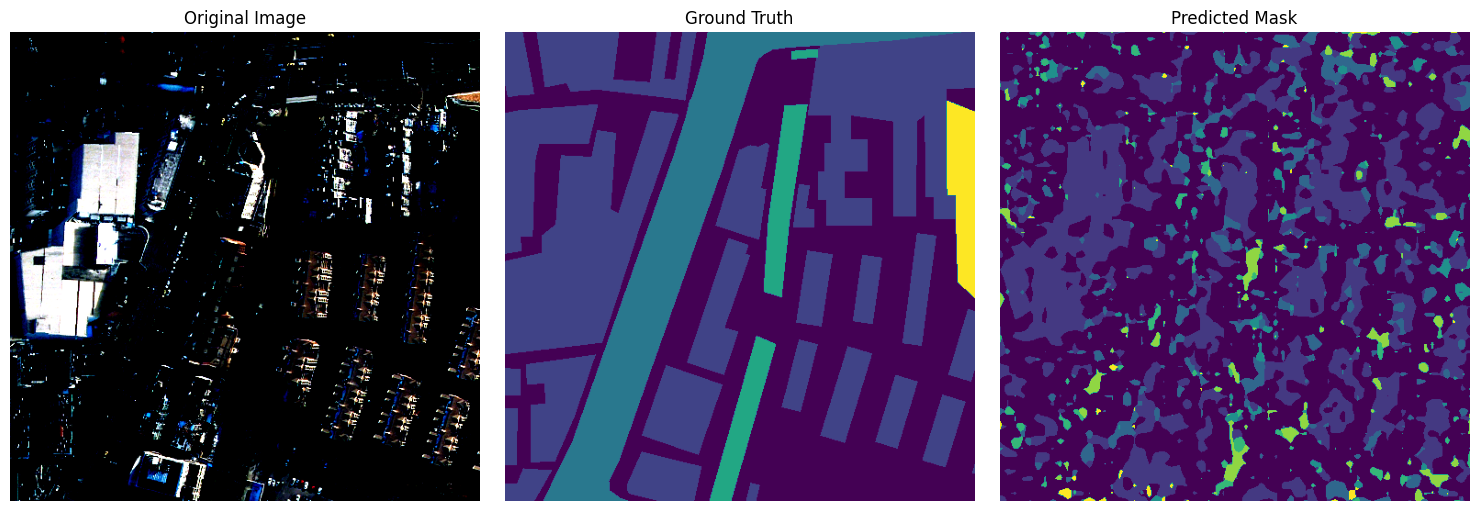

Starting epoch 4/20, LR = [0.002]
Loss at batch 0: 4.762630462646484
Loss at batch 1: 4.7023491859436035
Loss at batch 2: 4.832271099090576
Loss at batch 3: 4.6428446769714355
Loss at batch 4: 4.41849422454834
Loss at batch 5: 4.844877243041992
Loss at batch 6: 4.611260414123535
Loss at batch 7: 4.465032577514648
Loss at batch 8: 4.67860746383667
Loss at batch 9: 4.605606555938721
Loss at batch 10: 4.558732986450195
Loss at batch 11: 4.727047443389893
Loss at batch 12: 4.484943389892578
Loss at batch 13: 4.282646179199219
Epoch 4, Loss 13.90607500076294


model succesfully saved on drive. loss went down to 13.90607500076294
[EPOCH 4] Avg. Loss: 0.07211757131985255


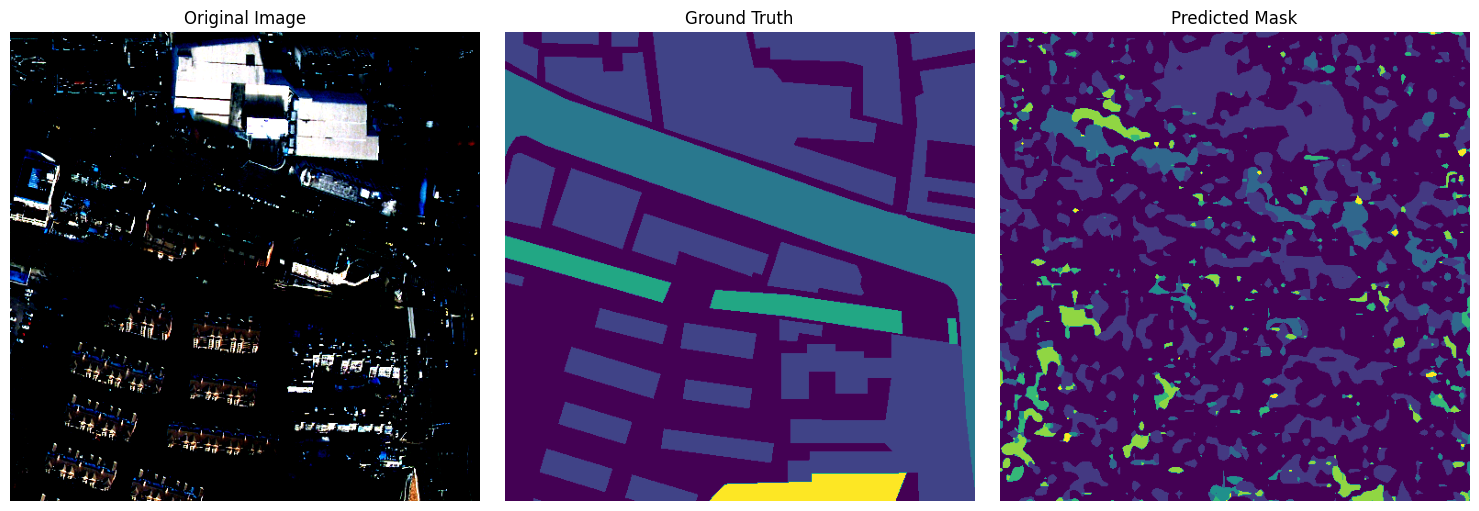

Starting epoch 5/20, LR = [0.002]
Loss at batch 0: 4.700200080871582
Loss at batch 1: 4.461485385894775
Loss at batch 2: 4.33663272857666
Loss at batch 3: 4.432465553283691
Loss at batch 4: 4.551238059997559
Loss at batch 5: 4.566193580627441
Loss at batch 6: 4.5547027587890625
Loss at batch 7: 4.314179420471191
Loss at batch 8: 4.31552267074585
Loss at batch 9: 4.26735782623291
Loss at batch 10: 4.0729546546936035
Loss at batch 11: 4.1132073402404785
Loss at batch 12: 4.269705772399902
Loss at batch 13: 4.707098960876465
Epoch 5, Loss 13.219123840332031


model succesfully saved on drive. loss went down to 13.219123840332031
[EPOCH 5] Avg. Loss: 0.0688202508858272


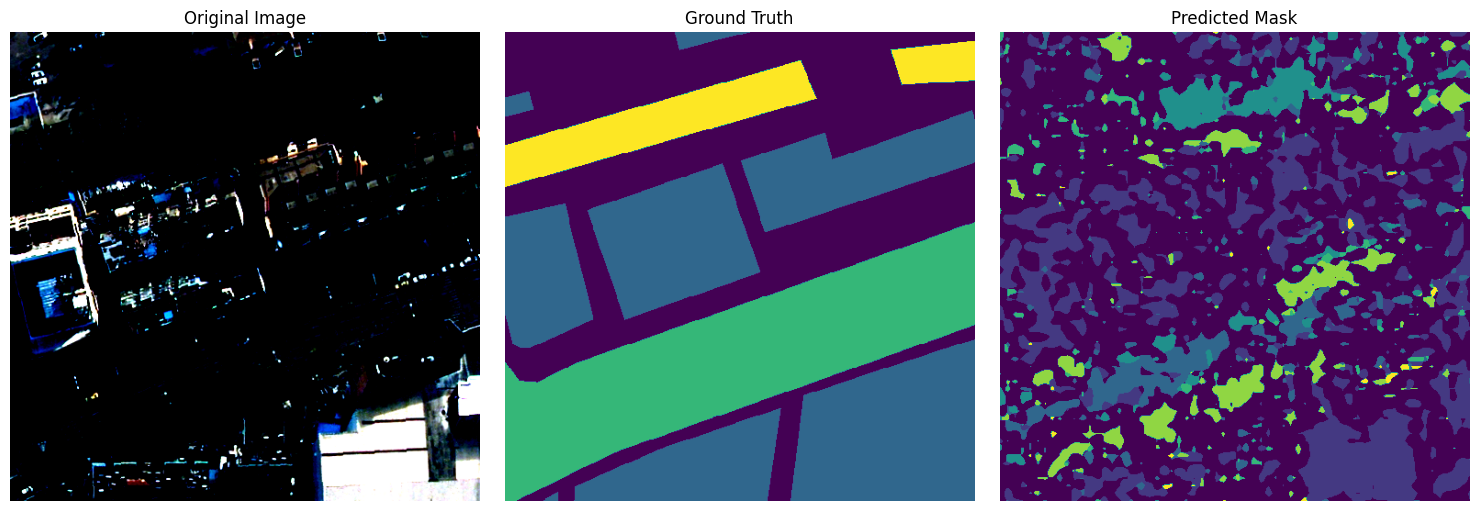

Starting epoch 6/20, LR = [0.002]
Loss at batch 0: 4.049737453460693
Loss at batch 1: 4.566359043121338
Loss at batch 2: 4.140838146209717
Loss at batch 3: 4.081665992736816
Loss at batch 4: 4.574153423309326
Loss at batch 5: 4.386910915374756
Loss at batch 6: 4.270077705383301
Loss at batch 7: 4.1877312660217285
Loss at batch 8: 4.417242050170898
Loss at batch 9: 4.5157270431518555
Loss at batch 10: 4.256863117218018
Loss at batch 11: 4.036351680755615
Loss at batch 12: 4.04412317276001
Loss at batch 13: 4.231522560119629
Epoch 6, Loss 12.735796451568604


model succesfully saved on drive. loss went down to 12.735796451568604
[EPOCH 6] Avg. Loss: 0.06669565130557333


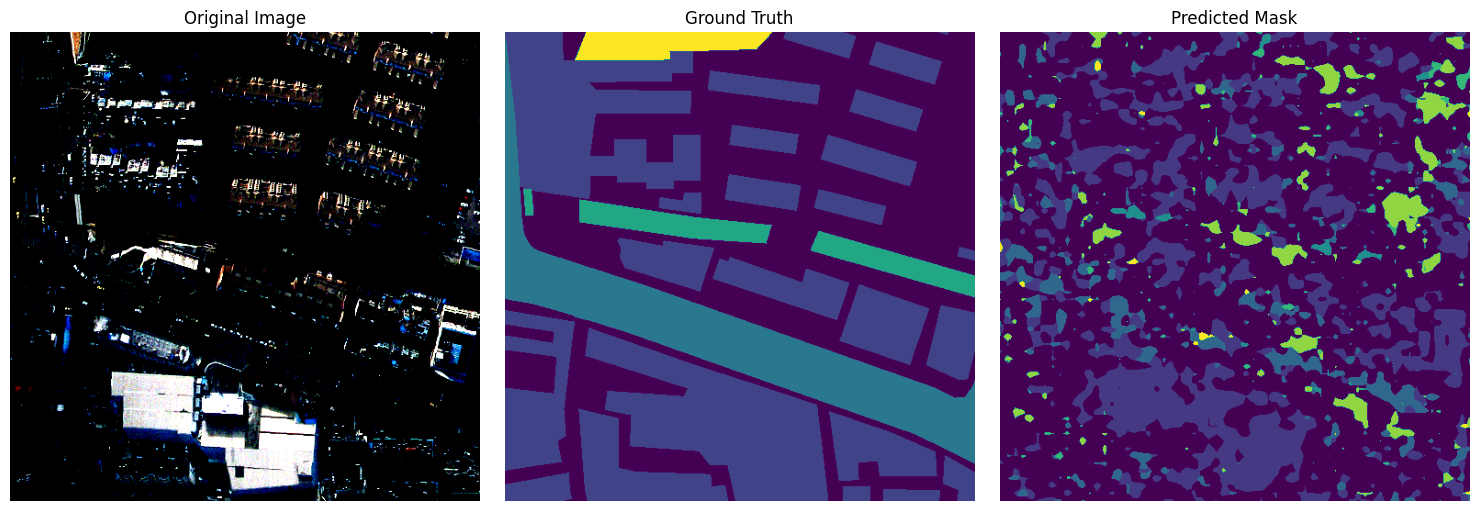

Starting epoch 7/20, LR = [0.002]
Loss at batch 0: 4.260030746459961
Loss at batch 1: 3.977804183959961
Loss at batch 2: 4.463794708251953
Loss at batch 3: 3.841886281967163
Loss at batch 4: 4.311443328857422
Loss at batch 5: 3.999124050140381
Loss at batch 6: 4.297728538513184
Loss at batch 7: 4.016546726226807
Loss at batch 8: 4.2291483879089355
Loss at batch 9: 3.995527744293213
Loss at batch 10: 4.123466968536377
Loss at batch 11: 4.122488021850586
Loss at batch 12: 4.307802200317383
Loss at batch 13: 4.013795852661133
Epoch 7, Loss 12.548609256744385


model succesfully saved on drive. loss went down to 12.548609256744385
[EPOCH 7] Avg. Loss: 0.06468815595975944


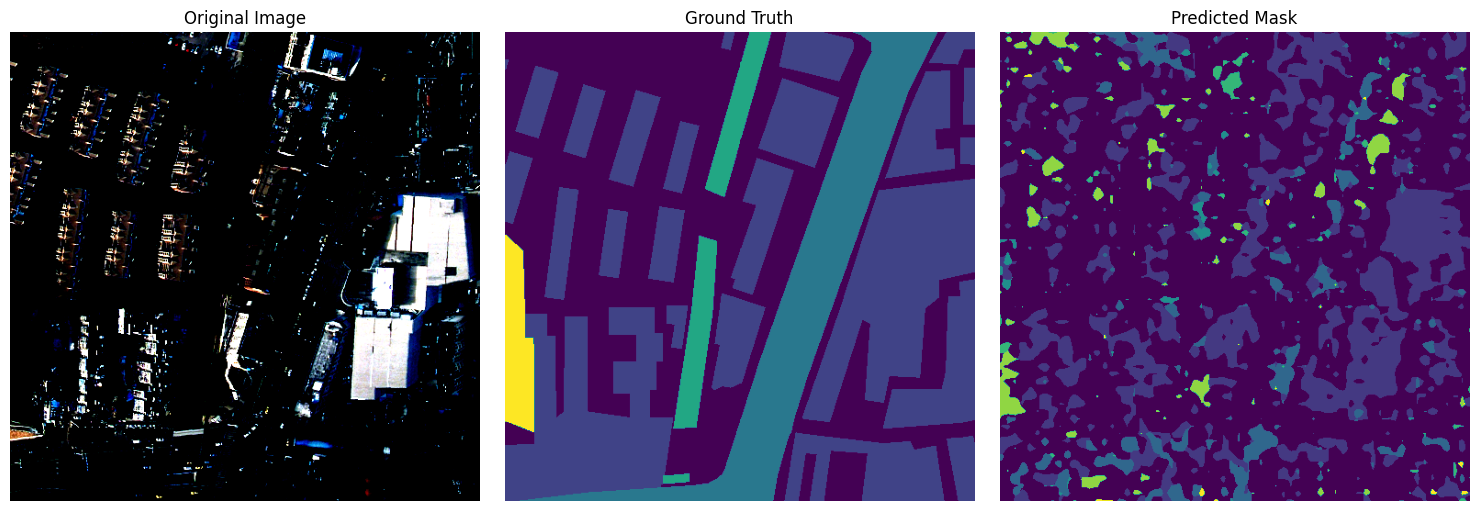

Starting epoch 8/20, LR = [0.002]
Loss at batch 0: 4.135806560516357
Loss at batch 1: 4.138354301452637
Loss at batch 2: 4.0091729164123535
Loss at batch 3: 4.208919525146484
Loss at batch 4: 4.142818450927734
Loss at batch 5: 3.9874696731567383
Loss at batch 6: 3.953152656555176
Loss at batch 7: 3.9270873069763184
Loss at batch 8: 3.880985736846924
Loss at batch 9: 4.229946613311768
Loss at batch 10: 4.098475933074951
Loss at batch 11: 4.152431964874268
Loss at batch 12: 4.278722286224365
Loss at batch 13: 3.776254415512085
Epoch 8, Loss 11.838534832000732


model succesfully saved on drive. loss went down to 11.838534832000732
[EPOCH 8] Avg. Loss: 0.06352633743413857


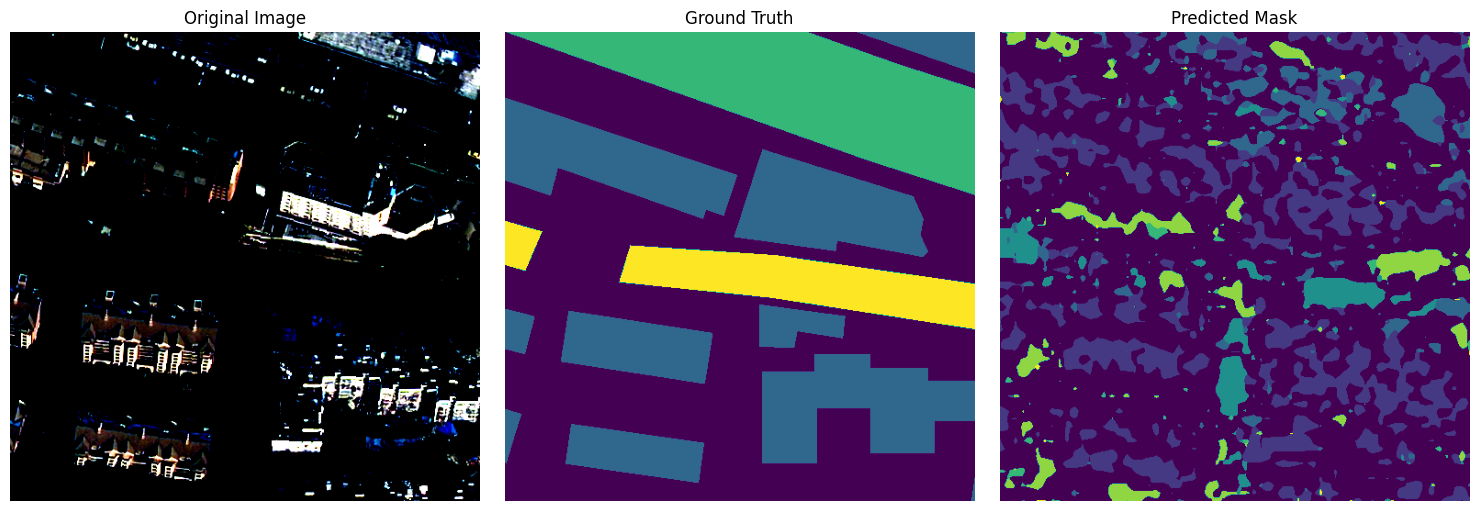

Starting epoch 9/20, LR = [0.002]
Loss at batch 0: 4.333995819091797
Loss at batch 1: 4.030757904052734
Loss at batch 2: 3.9348766803741455
Loss at batch 3: 4.286365985870361
Loss at batch 4: 4.12385368347168
Loss at batch 5: 4.054727077484131
Loss at batch 6: 3.8206727504730225
Loss at batch 7: 3.7387869358062744
Loss at batch 8: 3.9556636810302734
Loss at batch 9: 3.7878265380859375
Loss at batch 10: 3.96307373046875
Loss at batch 11: 3.8750624656677246
Loss at batch 12: 3.8960471153259277
Loss at batch 13: 3.886009693145752


Epoch 9, Loss 11.856841087341309
[EPOCH 9] Avg. Loss: 0.06215147328163896


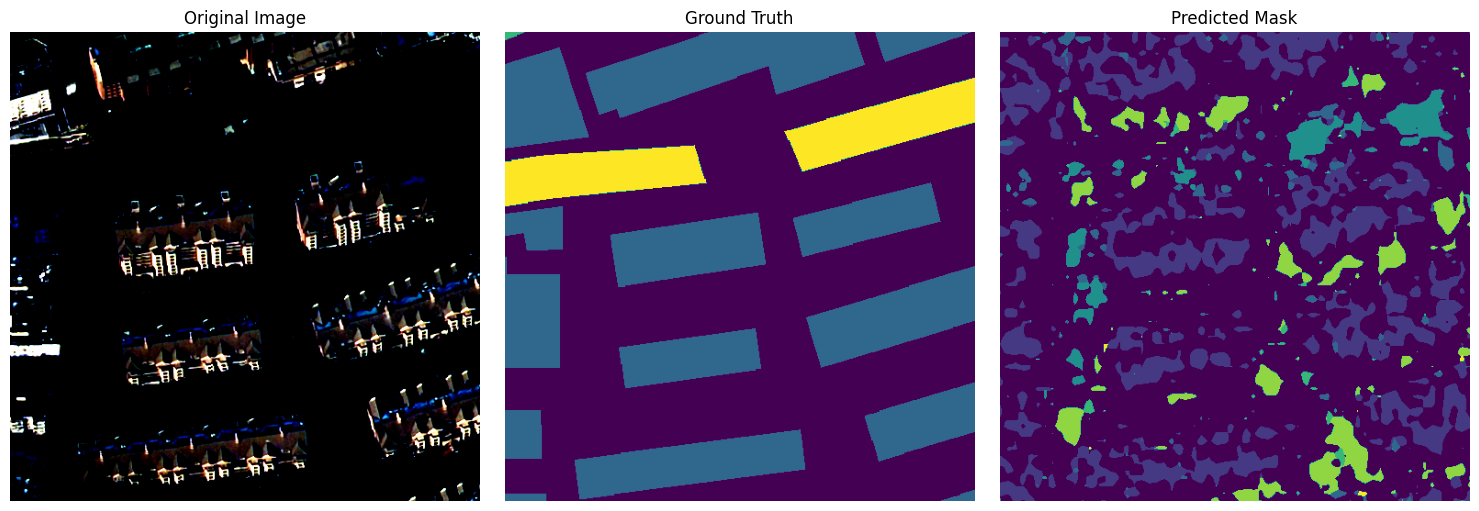

Starting epoch 10/20, LR = [0.002]
Loss at batch 0: 3.8604183197021484
Loss at batch 1: 3.7955374717712402
Loss at batch 2: 4.109986305236816
Loss at batch 3: 3.951143264770508
Loss at batch 4: 4.208071708679199
Loss at batch 5: 3.917975425720215
Loss at batch 6: 3.8187522888183594
Loss at batch 7: 4.061923027038574
Loss at batch 8: 3.873619794845581
Loss at batch 9: 4.01682710647583
Loss at batch 10: 3.851505756378174
Loss at batch 11: 3.9268200397491455
Loss at batch 12: 3.898320436477661
Loss at batch 13: 3.9863715171813965


Epoch 10, Loss 11.839536428451538
[EPOCH 10] Avg. Loss: 0.06169338444513934


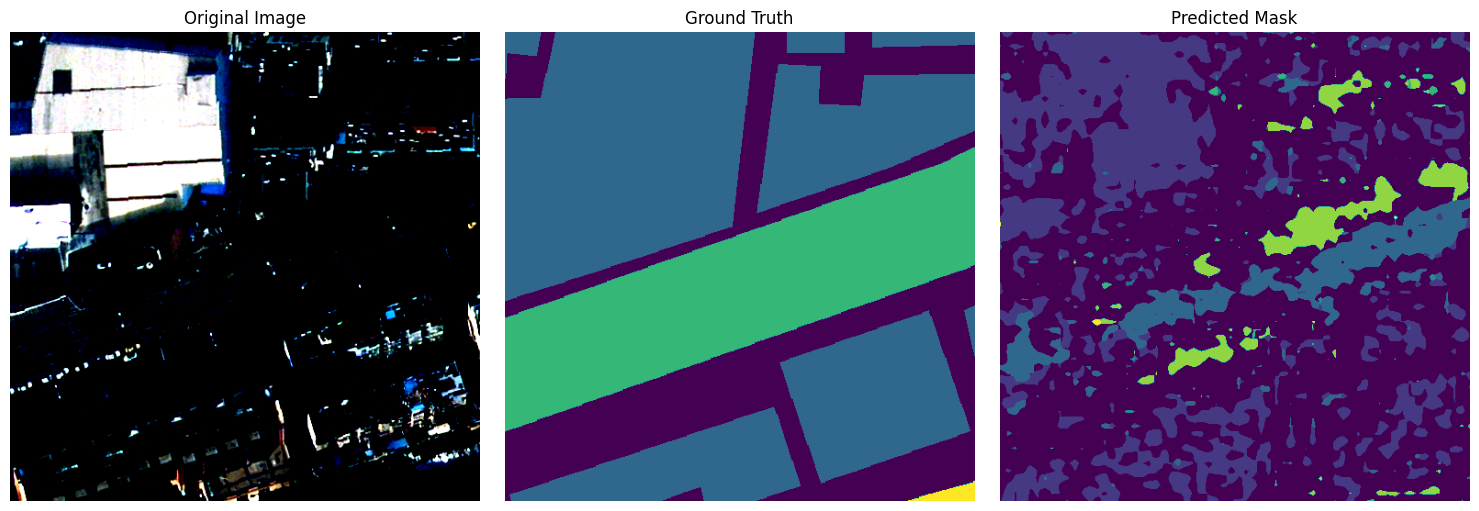

Starting epoch 11/20, LR = [0.002]
Loss at batch 0: 3.8213393688201904
Loss at batch 1: 3.9121499061584473
Loss at batch 2: 3.987022876739502
Loss at batch 3: 4.090742588043213
Loss at batch 4: 3.944732904434204
Loss at batch 5: 4.0707926750183105
Loss at batch 6: 3.68114972114563
Loss at batch 7: 3.805422306060791
Loss at batch 8: 4.143800258636475
Loss at batch 9: 4.472950458526611
Loss at batch 10: 3.5512571334838867
Loss at batch 11: 4.074310779571533
Loss at batch 12: 3.9936890602111816
Loss at batch 13: 3.7752809524536133
Epoch 11, Loss 11.769603729248047


model succesfully saved on drive. loss went down to 11.769603729248047
[EPOCH 11] Avg. Loss: 0.06174625110413347


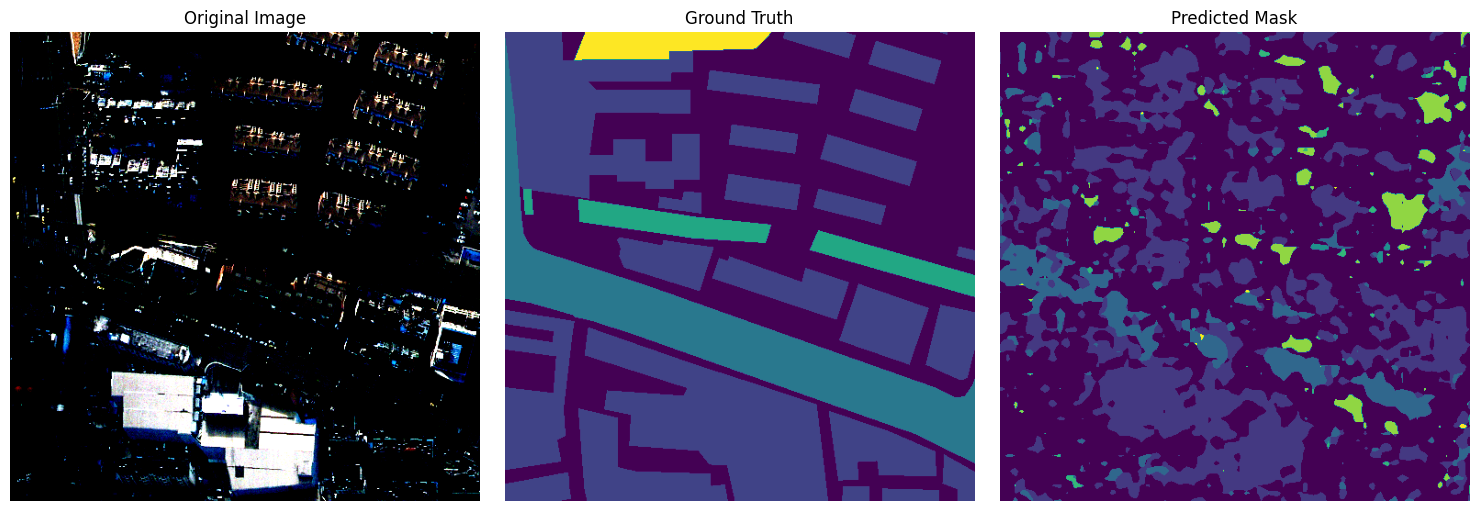

Starting epoch 12/20, LR = [0.002]
Loss at batch 0: 4.074003219604492
Loss at batch 1: 4.064902305603027
Loss at batch 2: 4.05588436126709
Loss at batch 3: 3.8077542781829834
Loss at batch 4: 3.779953956604004
Loss at batch 5: 3.887950897216797
Loss at batch 6: 3.972715377807617
Loss at batch 7: 3.8027005195617676
Loss at batch 8: 3.9312729835510254
Loss at batch 9: 3.5239500999450684
Loss at batch 10: 4.108952045440674
Loss at batch 11: 3.8639447689056396
Loss at batch 12: 4.033412933349609
Loss at batch 13: 3.909973621368408
Epoch 12, Loss 11.458620309829712


model succesfully saved on drive. loss went down to 11.458620309829712
[EPOCH 12] Avg. Loss: 0.06118010197366987


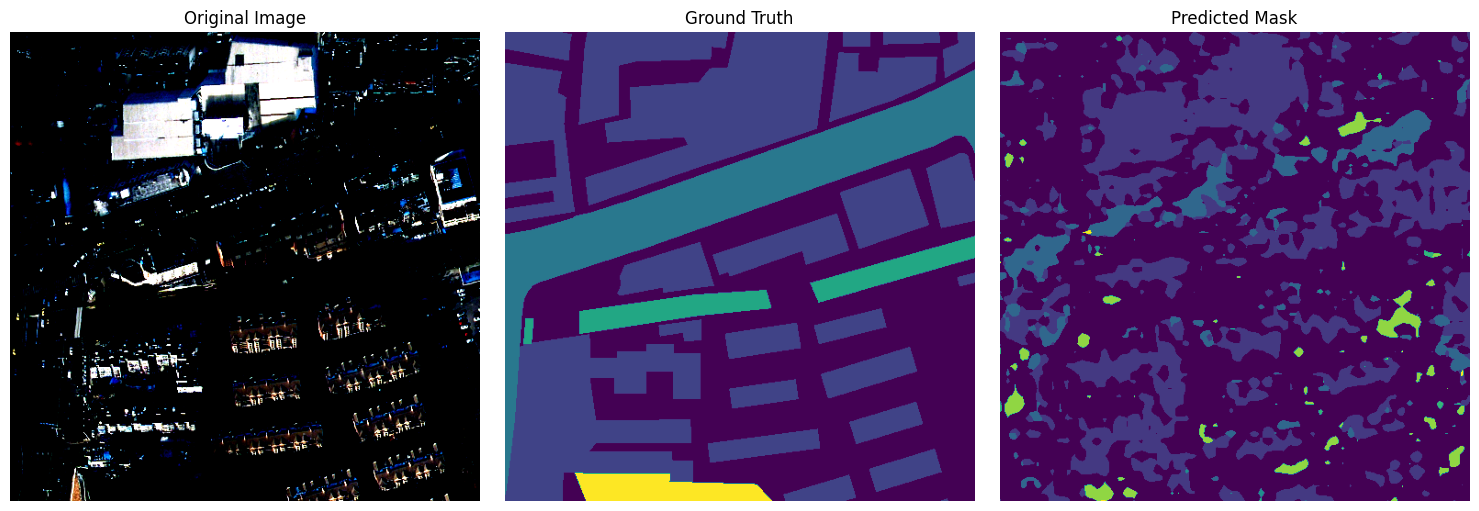

Starting epoch 13/20, LR = [0.002]
Loss at batch 0: 3.94154691696167
Loss at batch 1: 4.013067245483398
Loss at batch 2: 3.839578628540039
Loss at batch 3: 4.066191673278809
Loss at batch 4: 3.7084109783172607
Loss at batch 5: 4.221423625946045
Loss at batch 6: 4.059778690338135
Loss at batch 7: 3.71665620803833
Loss at batch 8: 3.7581238746643066
Loss at batch 9: 3.8403947353363037
Loss at batch 10: 3.9928460121154785
Loss at batch 11: 3.718517780303955
Loss at batch 12: 3.6966075897216797
Loss at batch 13: 3.775425910949707
Epoch 13, Loss 11.487499475479126
[EPOCH 13] Avg. Loss: 0.06065688601561955


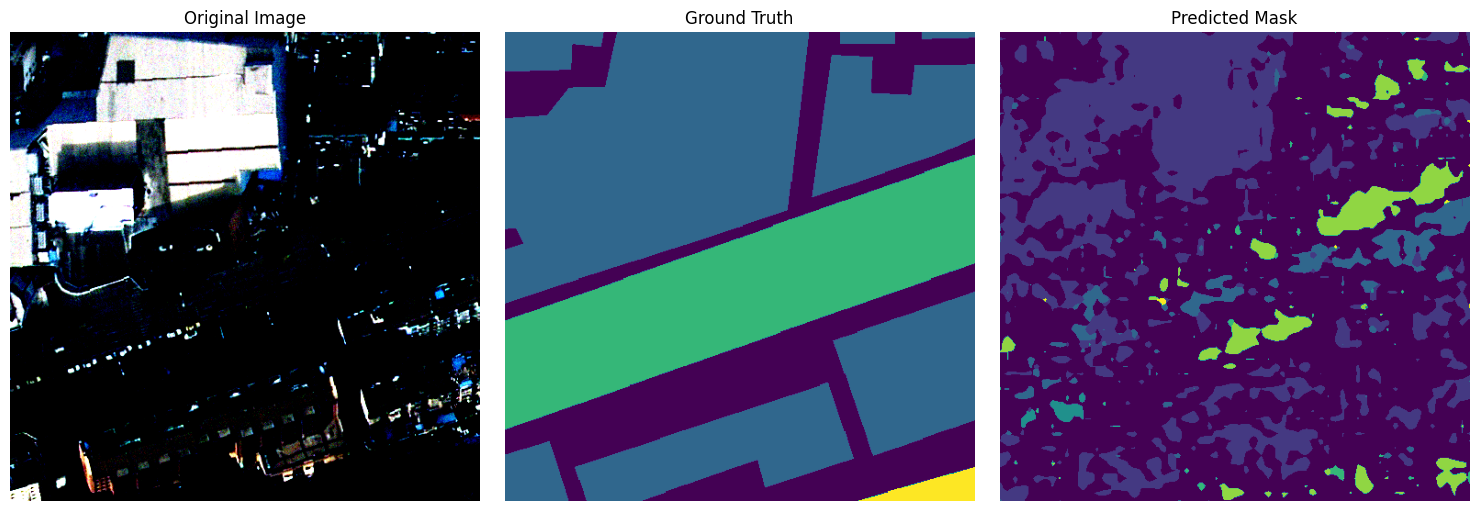

Starting epoch 14/20, LR = [0.002]
Loss at batch 0: 3.7387073040008545
Loss at batch 1: 3.7246954441070557
Loss at batch 2: 3.4201221466064453
Loss at batch 3: 3.9978199005126953
Loss at batch 4: 4.035501956939697
Loss at batch 5: 3.8413374423980713
Loss at batch 6: 3.9055562019348145
Loss at batch 7: 3.797534942626953
Loss at batch 8: 4.606279373168945
Loss at batch 9: 3.751768112182617
Loss at batch 10: 4.010412216186523
Loss at batch 11: 3.7621092796325684
Loss at batch 12: 3.752164840698242
Loss at batch 13: 3.57163405418396


Epoch 14, Loss 11.78631043434143
[EPOCH 14] Avg. Loss: 0.06017370894551277


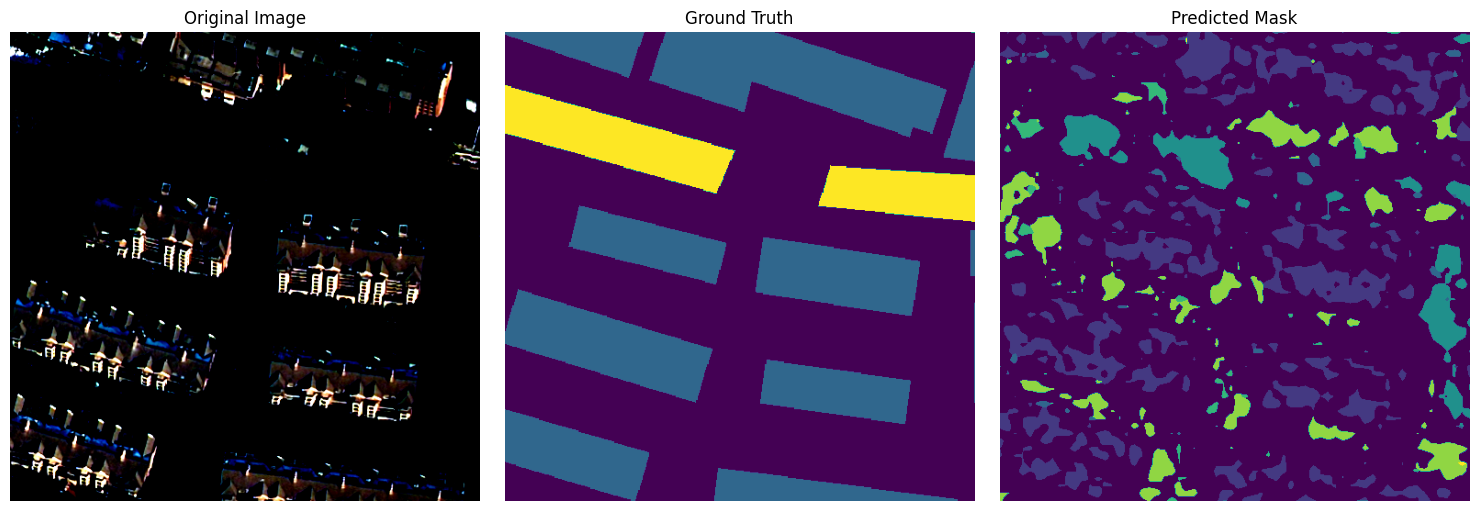

Starting epoch 15/20, LR = [2e-05]
Loss at batch 0: 3.827770233154297
Loss at batch 1: 3.658510208129883
Loss at batch 2: 3.867121458053589
Loss at batch 3: 3.7094287872314453
Loss at batch 4: 3.7758679389953613
Loss at batch 5: 3.556504011154175
Loss at batch 6: 3.8320505619049072
Loss at batch 7: 3.9854660034179688
Loss at batch 8: 3.8275551795959473
Loss at batch 9: 3.8738245964050293
Loss at batch 10: 3.8723220825195312
Loss at batch 11: 3.820106029510498
Loss at batch 12: 3.8051815032958984
Loss at batch 13: 3.6195640563964844
Epoch 15, Loss 11.278773546218872


model succesfully saved on drive. loss went down to 11.278773546218872
[EPOCH 15] Avg. Loss: 0.05918668822518417


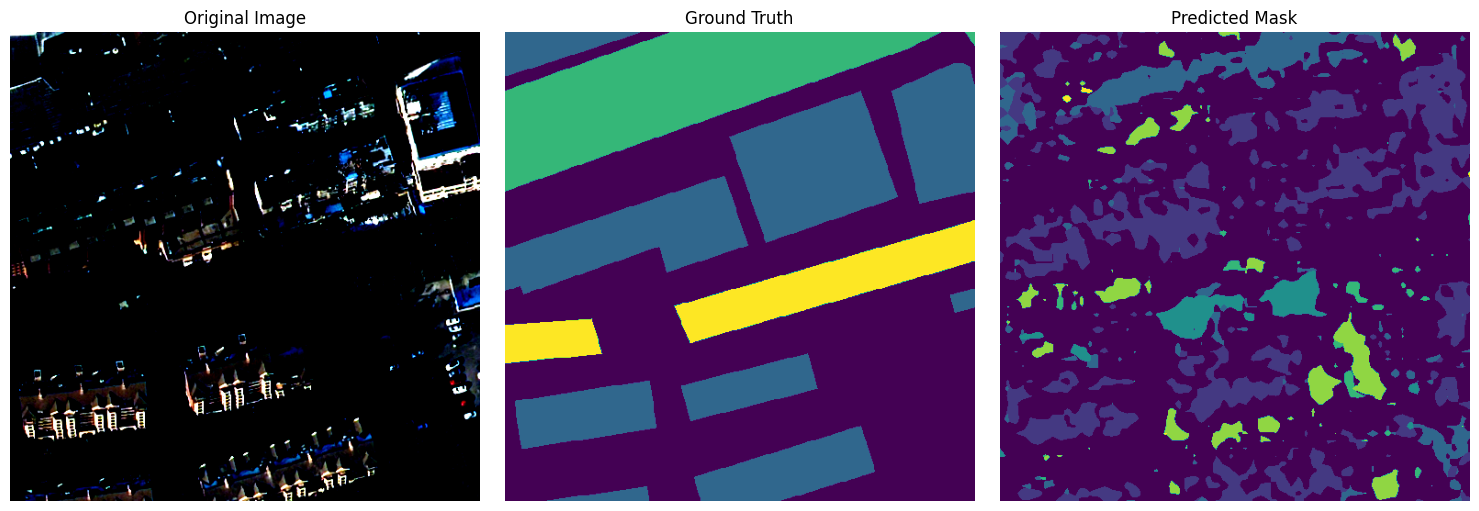

Starting epoch 16/20, LR = [0.0002]
Loss at batch 0: 3.8449008464813232
Loss at batch 1: 3.9629194736480713
Loss at batch 2: 3.7859370708465576
Loss at batch 3: 3.9397599697113037
Loss at batch 4: 3.70571231842041
Loss at batch 5: 3.78928804397583
Loss at batch 6: 3.65527081489563
Loss at batch 7: 3.7971720695495605
Loss at batch 8: 3.5435664653778076
Loss at batch 9: 3.8914570808410645
Loss at batch 10: 3.6843650341033936
Loss at batch 11: 3.8931446075439453
Loss at batch 12: 3.9997730255126953
Loss at batch 13: 3.716001272201538


Epoch 16, Loss 11.447054386138916
[EPOCH 16] Avg. Loss: 0.05938534385391644


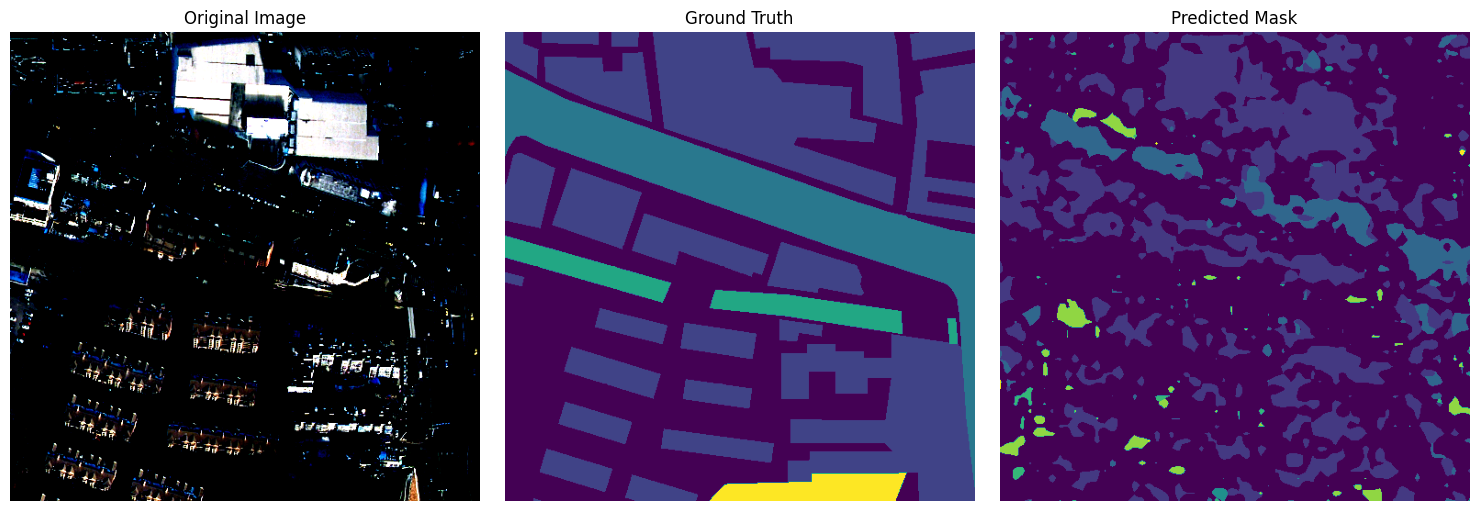

Starting epoch 17/20, LR = [0.0002]
Loss at batch 0: 3.9528751373291016
Loss at batch 1: 3.7228336334228516
Loss at batch 2: 3.6110336780548096
Loss at batch 3: 3.863520383834839
Loss at batch 4: 3.6265478134155273
Loss at batch 5: 3.8287272453308105
Loss at batch 6: 3.7764101028442383
Loss at batch 7: 3.8260838985443115
Loss at batch 8: 3.757667303085327
Loss at batch 9: 3.799107074737549
Loss at batch 10: 3.9369959831237793
Loss at batch 11: 3.844860792160034
Loss at batch 12: 3.7857344150543213
Loss at batch 13: 4.0286712646484375


Epoch 17, Loss 11.48407244682312
[EPOCH 17] Avg. Loss: 0.059554764202662876


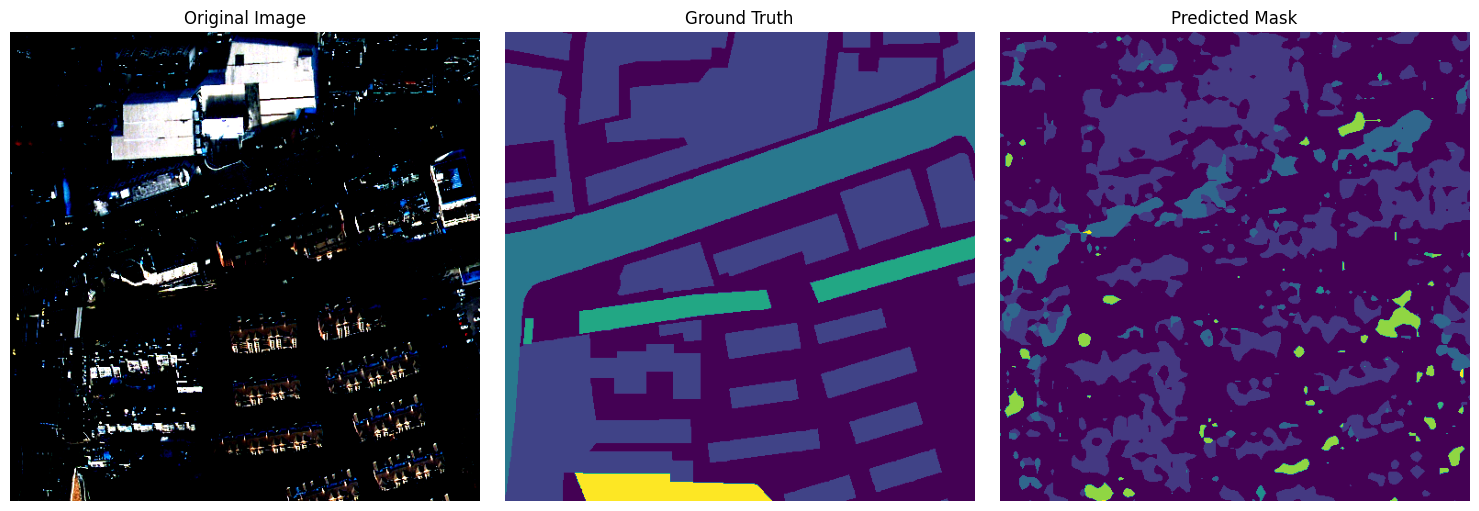

Starting epoch 18/20, LR = [0.0002]
Loss at batch 0: 4.047652244567871
Loss at batch 1: 3.449476957321167
Loss at batch 2: 3.674151659011841
Loss at batch 3: 3.8567087650299072
Loss at batch 4: 3.7703306674957275
Loss at batch 5: 3.8577880859375
Loss at batch 6: 3.80837082862854
Loss at batch 7: 3.9030754566192627
Loss at batch 8: 3.667412281036377
Loss at batch 9: 3.8871450424194336
Loss at batch 10: 3.5815258026123047
Loss at batch 11: 3.8135313987731934
Loss at batch 12: 3.8087117671966553
Loss at batch 13: 3.716078281402588


Epoch 18, Loss 11.420196533203125
[EPOCH 18] Avg. Loss: 0.05897540093532631


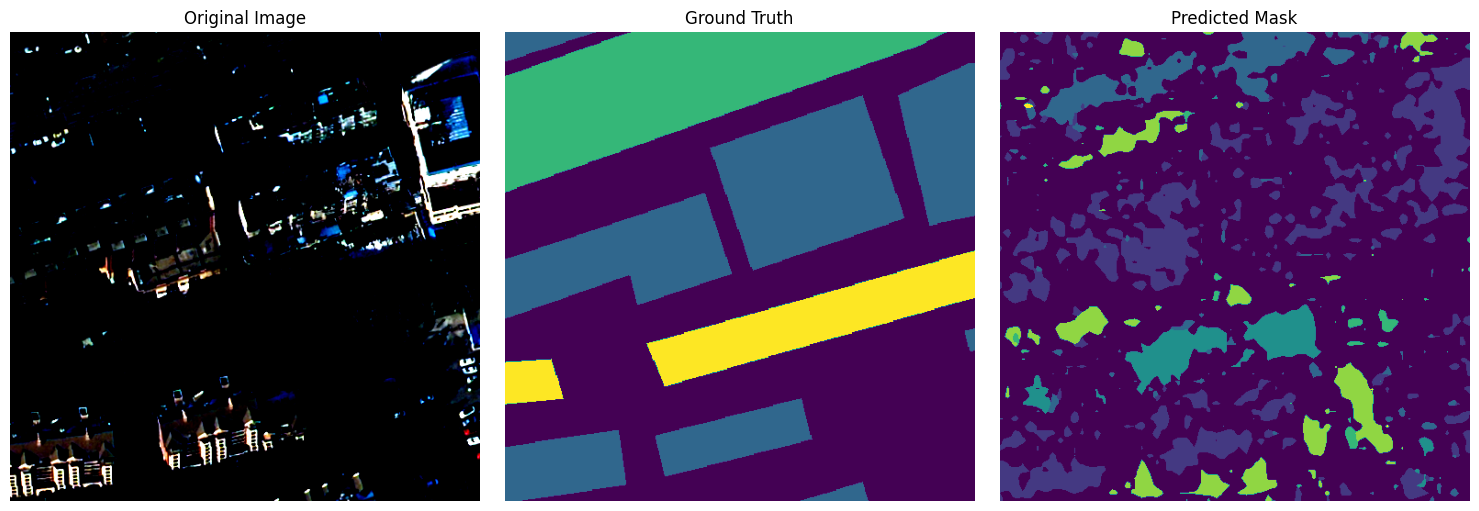

Starting epoch 19/20, LR = [0.0002]
Loss at batch 0: 3.8864803314208984
Loss at batch 1: 3.910451650619507
Loss at batch 2: 3.6916821002960205
Loss at batch 3: 3.754818916320801
Loss at batch 4: 3.595100164413452
Loss at batch 5: 3.7446224689483643
Loss at batch 6: 4.000178337097168
Loss at batch 7: 3.8296151161193848
Loss at batch 8: 3.901301860809326
Loss at batch 9: 3.5669808387756348
Loss at batch 10: 3.6662185192108154
Loss at batch 11: 3.618974208831787
Loss at batch 12: 3.591127395629883
Loss at batch 13: 3.7670228481292725


Epoch 19, Loss 11.389883518218994
[EPOCH 19] Avg. Loss: 0.058621177183730264


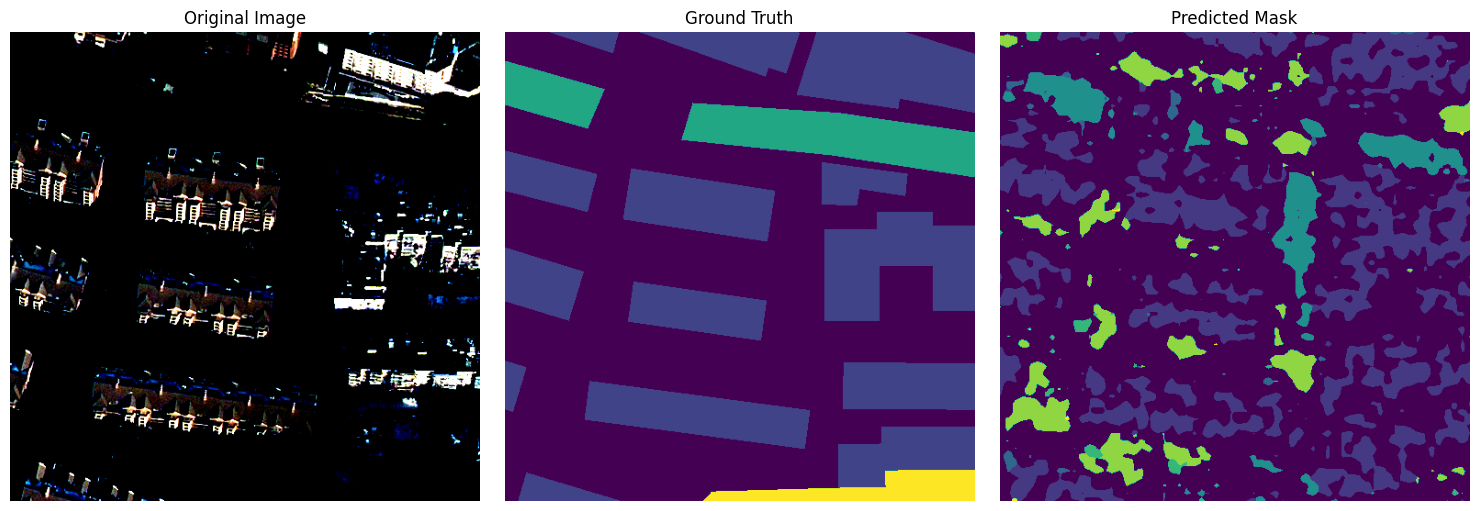

Starting epoch 20/20, LR = [0.0002]
Loss at batch 0: 3.68947434425354
Loss at batch 1: 3.6328225135803223
Loss at batch 2: 3.7073583602905273
Loss at batch 3: 4.17537260055542
Loss at batch 4: 3.824984550476074
Loss at batch 5: 3.7979562282562256
Loss at batch 6: 3.702569007873535
Loss at batch 7: 3.864047050476074
Loss at batch 8: 3.719059944152832
Loss at batch 9: 3.5964980125427246
Loss at batch 10: 3.8474385738372803
Loss at batch 11: 3.877500295639038
Loss at batch 12: 3.657719135284424
Loss at batch 13: 3.878723382949829


Epoch 20, Loss 11.657512187957764
[EPOCH 20] Avg. Loss: 0.05912000446447304


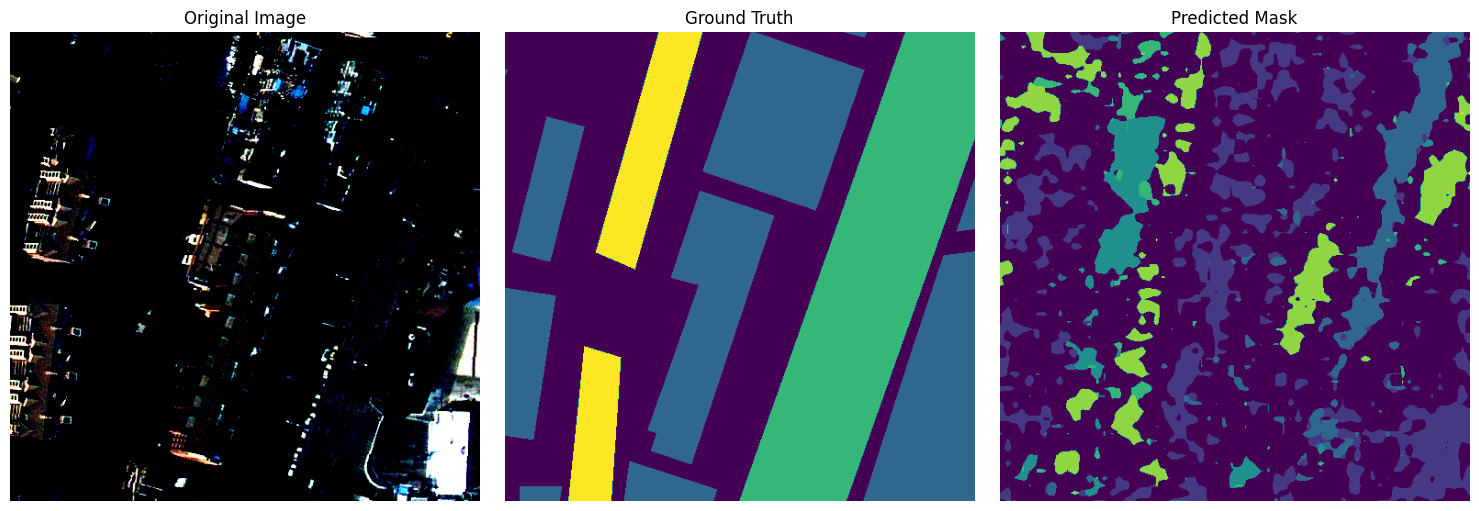

In [ ]:
import matplotlib.pyplot as plt

# For easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

SAVE_MODEL_AS = 'best_model_aug1.pth'

current_step = 0

best_loss = float('inf')
best_model = model.state_dict()

model = model.to(DEVICE)
print(f"DEVICE is {DEVICE}")
if TYPE == 'Train':
  for epoch in range(NUM_EPOCHS):
    model.train()
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    epoch_loss = [0.0, 0]
    for (batch_i, batch) in enumerate(train_loader):
        optimizer.zero_grad()

        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)
        # print(f"DEBUG: image path: {img_path}")
        # print(f"DEBUG: image batch shape: {images.shape}")
        # print(f"DEBUG: mask batch shape: {masks.shape}")

        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images) # in model.train() mode batch size must be > 1 I think
                                # NOTE: we have 3 heads (i.e. 3 outputs) but 4 losses: 2nd head is used for both S and BAS

        ## Upscale (bilinear interpolation - not learned)
        h, w = masks.size(1), masks.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        # print(f"DEBUG: outputs shapes below: ({len(outputs)} of them)")
        # for output in outputs:
        #     print(output.shape)
        # print(f"DEBUG: in particular, shape of outputs[-2] is {outputs[-2].shape}")

        ## Losses
        # Semantic Losses (l_0 and l_2)
        loss_s = sem_loss(outputs[:-1], masks) # output #1 and #2 are segmentation predictions (i.e. low level (P) and high+low level (PI) respectively)

        # Boundary Loss (l_1)
        loss_b = bd_loss(outputs[-1], bd_gts) # output #3 is the boundary prediction

        # Boundary AwareneSS (BAS) Loss (l_3)
        filler = torch.ones_like(masks) * -1
        bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
                            # REMEMBER to wrap in list, as the checks in ce use that to know what to do
        loss_sb = sem_loss([outputs[-2]], bd_label) # output #2 is the PI segmentation prediction, done here in BAS mode (see `filler` variable)

        # Complete Loss
        loss = loss_s + loss_b + loss_sb # The coefficients of the sum of the four losses (0.4, 20, 1, 1) are taken into account in the various `sem_loss` and `bd_loss`
        ### <=== Forward, Upscale, Compute Losses

        ### Backprop
        if batch_i % LOG_FREQUENCY == 0:
            print(f'Loss at batch {batch_i}: {loss.item()}')
        loss.backward()

        optimizer.step()
        epoch_loss[0] += loss.item()
        epoch_loss[1] += images.size(0)

    # Evaluate model on the evaluation set and save the parameters if is better than best model
    model.eval()
    total_loss = 0.0
    outputs = []
    with torch.no_grad():
      for (batch_i, batch) in enumerate(validation_loader):
        ### Extract input
        images, masks, img_path, bd_gts = batch
        images = images.float().to(DEVICE)
        masks = masks.to(DEVICE)
        bd_gts = bd_gts.float().to(DEVICE)

        ### ===> Forward, Upscale, Compute Losses
        ## Forward
        outputs = model(images)

        ## Upscale (bilinear interpolation - not learned)
        h, w = masks.size(1), masks.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        ## Losses
        # Semantic Losses (l_0 and l_2)
        loss_s = sem_loss(outputs[:-1], masks)

        # Boundary Loss (l_1)
        loss_b = bd_loss(outputs[-1], bd_gts)

        # Boundary AwareneSS (BAS) Loss (l_3)
        filler = torch.ones_like(masks) * -1
        bd_label = torch.where(F.sigmoid(outputs[-1][:,0,:,:]) > 0.8, masks, filler)
        loss_sb = sem_loss([outputs[-2]], bd_label)

        # Complete Loss
        loss = loss_s + loss_b + loss_sb
        ### <=== Forward, Upscale, Compute Losses
        total_loss += loss.item()

    print('Epoch {}, Loss {}'.format(epoch+1, total_loss))
    if total_loss < best_loss:
      best_loss = total_loss
      best_model = model.state_dict()
      #Save in Drive and local
      torch.save(best_model, SAVE_MODEL_AS)
      if SAVE_ON_DRIVE:
        !cp {SAVE_MODEL_AS} /content/drive/MyDrive/LoveDA/{SAVE_MODEL_AS}
        print(f"model succesfully saved on drive. loss went down to {best_loss}")

    current_step += 1
    scheduler.step()
    print(f'[EPOCH {epoch+1}] Avg. Loss: {epoch_loss[0] / epoch_loss[1]}')

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Plot the ground truth mask
    axes[1].imshow(masks[0].cpu().numpy())
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Plot the predicted mask
    axes[2].imshow(torch.argmax(outputs[0][0], dim=0).cpu().numpy())
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    # Display the figure
    plt.tight_layout()
    plt.show()

# TEST

In [ ]:
!pip install torchmetrics ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.0 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy
from tqdm import tqdm
import time
import ptflops

TYPE = 'Test'
TARGET = 'Urban'
#Load best_model
#!cp /content/drive/MyDrive/LoveDA/best_model_step2b.pth /content/best_model_step2b.pth


model = get_seg_model(cfg, imgnet_pretrained=False)
best_model = torch.load('/content/best_model_aug1.pth', weights_only=True)
model.load_state_dict(best_model)
model = model.to(DEVICE)

accuracy, mIoU = True, True

#using type = train i have more images (0.8)
test_dataset = LoveDADataset(transforms=AUGMENTATIONS['Normalize'], split=TARGET, type='Validation', validation_ratio=0.2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True, pin_memory=True)

#### TEST LOOP
model.eval()

# Latency
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):
        _ = model(torch.randn(1, 3, RESIZE, RESIZE).to(DEVICE))
    end_time = time.time()
latency = (end_time - start_time) / 100
print(f"Latency: {latency:.4f} seconds")

# FLOPs
macs, _ = ptflops.get_model_complexity_info(model,
  (3, RESIZE, RESIZE), as_strings=False,
  print_per_layer_stat=False, verbose=False)
flops = macs * 2  # MACs perform two FLOPs
print("FLOPs:", flops)

# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

if TYPE == 'Test':
  with torch.no_grad():
      total_union = torch.zeros(NUM_CLASSES).to(DEVICE)
      total_intersection = torch.zeros(NUM_CLASSES).to(DEVICE)
      meter = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(DEVICE)
      for (batch) in tqdm(test_loader):
          ### Extract input
          images, masks, img_path, bd_gts = batch
          images = images.float().to(DEVICE)
          masks = masks.to(DEVICE)

          ### ===> Forward, Upscale, Compute Losses
          ## Forward
          outputs = model(images)

          ## Upscale (bilinear interpolation - not learned)
          h, w = masks.size(1), masks.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          # Output 1 is the prediction

          # Shape: NBATCHES x classes x h x w
          class_indices = torch.argmax(outputs[1], dim=1)  # Shape: NBATCHES x h x w

          if accuracy:
          # Create a mask for valid targets (where target is not -1)
            valid_mask = (masks != -1)  # Mask of shape: NBATCHES x h x w
            # Apply the mask to ignore -1 targets when updating the accuracy metric
            meter.update(class_indices[valid_mask], masks[valid_mask])

          if mIoU:
            for predicted, target in zip(class_indices, masks):
              for i in range(NUM_CLASSES):
                total_intersection[i] += torch.sum(torch.logical_and(predicted == i, target == i))
                total_union[i] += torch.sum(torch.logical_or(predicted == i, target == i))

  if accuracy:
    accuracy = meter.compute()
    print(f'\nAccuracy on the target domain: {100 * accuracy:.2f}%')

  if mIoU:
    intersection_over_union = total_intersection / total_union

    # Per class IoU
    for i, iou in enumerate(intersection_over_union):
        class_name = list(LABEL_MAP.keys())[list(LABEL_MAP.values()).index(i)]  # Get the class name from LABEL_MAP
        print(f'{class_name} IoU: {iou:.4f}')

    mIoU = torch.mean(intersection_over_union)
    print(f'\nmIoU on the target domain: {mIoU}')


<ipython-input-128-d799b7f58ec7>:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')


Dataset size: 232
Latency: 0.0160 seconds
FLOPs: 12682936320
Total number of parameters: 7717839


100%|██████████| 3/3 [00:12<00:00,  4.32s/it]


Accuracy on the target domain: 62.74%
Background IoU: 0.4972
Building IoU: 0.3923
Road IoU: 0.4195
Water IoU: 0.3150
Barren IoU: 0.3664
Forest IoU: 0.3987
Agricultural IoU: 0.1428

mIoU on the target domain: 0.36168721318244934
